# **"Telecom" Project**



## Task description

The task is to learn how to predict customer churn from a mobile operator company. If it turns out that the user plans to leave, they will be offered promo codes and special conditions. The operator has collected personal data about some customers, information about their tariffs and contracts.

The operator provides two main types of services:

1. Landline telephone communication. It is possible to connect a telephone set to several lines simultaneously.
2. Internet. Connection can be of two types: via a telephone line (DSL) or fiber optic cable.

The following services are also available:

- Internet security: antivirus (DeviceProtection) and blocking of unsafe sites (OnlineSecurity);
- Dedicated technical support line (TechSupport);
- Cloud file storage for data backup (OnlineBackup);
- Streaming TV (StreamingTV) and movie catalog (StreamingMovies).

Customers can pay for services monthly or enter into a contract for 1-2 years. Various payment methods are available, as well as the ability to receive an electronic receipt.

The data consists of files obtained from different sources:

- `contract.csv` - information about the contract;
- `personal.csv` - customer personal data;
- `internet.csv` - information about internet services;
- `phone.csv` - information about telephone services.

In all files, the `customerID` column contains the customer code.

Information about contracts is valid as of February 1, 2020.

Task:

Train a model that would predict whether the customer will leave or not. The AUC-ROC metric is at least 0.75.

## Work Plan

- Problem overview, goal setting
- Library import block
- Loading and initial data review
- Table merging
- Missing data processing
- Feature creation/deletion
- Feature correlation analysis
- Splitting the dataset into test and train sets
- Feature encoding (One-hot)
- Model training
- Model comparison
- Final testing on the test set
- Feature importance analysis

## Import libraries

In [1]:
! pip install -q phik
! pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import cv, Pool

import phik
from phik.report import plot_correlation_matrix
from phik import report

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading and initial data exploration

In [3]:
try:
  ! unzip -o /content/drive/MyDrive/Practicum_projects/Telecom/final_provider.zip
except:
  print('Error')

Archive:  /content/drive/MyDrive/Practicum_projects/Telecom/final_provider.zip
   creating: final_provider/
  inflating: final_provider/personal.csv  
  inflating: __MACOSX/final_provider/._personal.csv  
  inflating: final_provider/contract.csv  
  inflating: final_provider/phone.csv  
  inflating: __MACOSX/final_provider/._phone.csv  
  inflating: final_provider/internet.csv  


### "Contract" table

In [4]:
try:
  df_contract = pd.read_csv('/content/final_provider/contract.csv')
except:
  print('Error')

In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2051,5346-BZCHP,2014-05-01,No,Two year,No,Mailed check,19.4,1346.2
623,5148-HKFIR,2018-06-01,No,Two year,No,Mailed check,19.7,406.95
6557,8709-KRDVL,2017-05-01,No,Month-to-month,Yes,Electronic check,100.0,3320.6


In [7]:
df_contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [8]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


These users registered at the time of table extraction from the database and have not yet paid. Let's change the spaces in the `TotalCharges` column to the value from the `MonthlyCharges` column, assuming that the user pays for the services in advance. We will convert the data in the column to `float` type to be able to view the histogram.

In [9]:
df_contract.loc[df_contract['TotalCharges'] == ' ', 'TotalCharges'] = df_contract['MonthlyCharges']

In [10]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

In [11]:
df_contract['TotalCharges'].describe()

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [12]:
df_contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

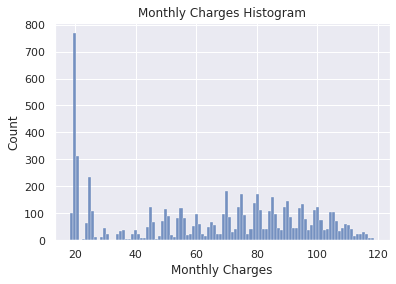

In [13]:
a = sns.histplot(df_contract, x='MonthlyCharges', bins=100)
a.set(xlabel='Monthly Charges', ylabel='Count', 
      title='Monthly Charges Histogram')
plt.show()

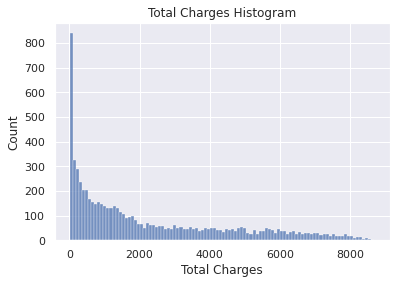

In [14]:
a = sns.histplot(df_contract, x='TotalCharges', bins=100)
a.set(xlabel='Total Charges', ylabel='Count', 
      title='Total Charges Histogram')
plt.show()

In [15]:
len(df_contract['customerID'].unique())

7043

In [16]:
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'].count()/ df_contract['EndDate'].count()

0.7346301292063041

In [17]:
df_contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [18]:
df_contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [19]:
df_contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [20]:
df_contract['BeginDate'].min()

'2013-10-01'

In [21]:
df_contract[df_contract['EndDate'] != 'No']['EndDate'].min()

'2019-10-01 00:00:00'

In [22]:
df_contract[df_contract['EndDate'] != 'No']['EndDate'].max()

'2020-01-01 00:00:00'

### Conclusion

This is a table with information about concluded contracts. It contains 8 columns with 7043 rows each, without gaps (except for those we have already processed).

- `customerID` - a unique user identifier, not repeated, occurs in all tables, useful for merging. Remove before training models.
- `BeginDate` - contract conclusion date, available for each client.
- `EndDate` - contract expiration date. For most (73.5%) users, the value is `No`. If a date is specified, the user has left. In accordance with our task, we will replace it with a binary column Left/Not Left.
- `Type` - categorical feature containing information about contract types. There are three of them: monthly payment, yearly, biyearly.
- `PaperlessBilling` - binary feature. Whether bills are sent in paper form or not.
- `PaymentMethod` - categorical feature with information about the payment method. There are 4 methods in total.
- `MonthlyCharges` - quantitative feature with information about the monthly expenses of the subscriber.
- `TotalCharges` - quantitative feature with information about the total expenses of the subscriber over the entire contract period.

Looking at the histogram of monthly expenses (`MonthlyCharges`), it can be seen that the distribution is quite uniform, except for a sharp peak around $19-20 (obviously, subscribers with a minimum package of services). Also, peaks located at regular intervals in price are clearly visible. This may indicate the popularity of certain service packages among subscribers. The mean does not differ much from the median.

On the histogram of total expenses (`TotalCharges`), a geometric distribution is clearly visible, which is quite obvious: there are almost always fewer old clients than new ones, so there will be significantly more those who spent a little money over the entire period of their relationship with the company. The mean is much greater than the median.

The data is provided from the end of 2013, data on departed customers is available for November-December 2019.

### "Internet" table

In [23]:
try:
  df_internet = pd.read_csv('/content/final_provider/internet.csv')
except:
  print('Error')

In [24]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [25]:
df_internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3179,0757-WCUUZ,DSL,No,No,Yes,No,No,Yes
2105,6997-UVGOX,DSL,Yes,Yes,Yes,Yes,Yes,Yes
1129,9350-VLHMB,Fiber optic,No,Yes,No,No,No,Yes


In [26]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [27]:
df_internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

### Conclusion

This is a table with information about internet services. It contains 8 columns with 5517 rows in each, without any missing values.

- `customerID` - unique identifier of the user, as in the previous table.
- `InternetService` - categorical feature with 2 unique values. It contains information about the type of connection used by the subscriber. When merging tables, a third value `no_internet` can be added for subscribers who do not use the internet.
- `OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies` - binary columns containing information about connected services.

This table has one and a half thousand entries less than the table with contracts. Not all people use the internet.


### "Personal" table

In [28]:
try:
  df_personal = pd.read_csv('/content/final_provider/personal.csv')
except:
  print('Error')

In [29]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [30]:
df_personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
2813,6484-LATFU,Male,0,No,No
1416,4859-ZSRDZ,Female,0,Yes,Yes
296,6556-DBKZF,Female,0,Yes,Yes


In [31]:
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [32]:
df_personal['SeniorCitizen'].unique()

array([0, 1])

### Conclusion

This is a table with information about subscribers. It contains 5 columns with 7043 rows in each, without gaps.

- `customerID` - a unique identifier of the user as in the previous tables.
- `gender` - a binary feature indicating the gender of the subscriber.
- `SeniorCitizen` - a binary feature indicating whether the subscriber has senior status.
- `Partner` - a binary feature indicating whether the subscriber has a partner.
- `Dependents` - a binary feature indicating whether the subscriber has dependents.

The number of entries in this table coincides with the number of entries in the contract table, which means that there is a subscriber for each contract. Some binary features are written in the format `0, 1`, some in the format `Yes, No`, in the final table they will need to be brought to a single format.

### "Phone" table

In [33]:
try:
  df_phone = pd.read_csv('/content/final_provider/phone.csv')
except:
  print('Error')

In [34]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [35]:
df_phone.sample(3)

,customerID,MultipleLines
4753,8777-MBMTS,No
5515,5119-KEPFY,Yes
3424,4201-JMNGR,No


### Conclusion

This is a table with information about telephone services. It contains 2 columns with 6361 rows in each, without any gaps.

- `customerID` - a unique identifier for the user, as in the previous tables.
- `MultipleLines` - a binary feature that reflects the presence of a service for connecting a phone to multiple lines simultaneously.

The number of subscribers using the phone is less than the total number of subscribers; not all subscribers use the phone. At the stage of combining tables, we will turn the binary `MultipleLines` into a categorical feature and add a third unique value, `no_phone`.

## Data Processing and Tables Merging

### Processing the "contract" table

In [36]:
df_contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [37]:
df_contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']

Let's create a column with the target variable.

In [38]:
df_contract.loc[df_contract['end_date'] != 'No', 'left'] = 1
df_contract['left'] = df_contract['left'].fillna(0)

Let's calculate how many days each subscriber has been a customer of the company at the time of dataset extraction.

In [39]:
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d %H:%M:%S')

df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [40]:
df_contract['loyalty'] = df_contract['end_date'] - df_contract['begin_date']

In [41]:
def days(td):
    return td.days

In [42]:
df_contract['loyalty'] = df_contract['loyalty'].apply(days)

In [43]:
df_contract = df_contract.drop(['begin_date', 'end_date'], axis=1)

In [44]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 440.3+ KB


In [45]:
df_contract.sample(3)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,left,loyalty
6802,5626-MGTUK,Month-to-month,Yes,Bank transfer (automatic),89.10,1879.25,0.0,610
3158,7410-KTVFV,Month-to-month,Yes,Mailed check,49.55,878.35,1.0,549
5417,9715-SBVSU,Two year,Yes,Bank transfer (automatic),61.40,815.55,0.0,427


### Processing the "internet" table

In [46]:
df_internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [47]:
df_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [48]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [49]:
df_internet.sample(3)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1460,9359-JANWS,DSL,Yes,No,Yes,Yes,No,No
537,7538-GWHML,Fiber optic,No,No,No,No,No,No
5039,2669-QVCRG,Fiber optic,Yes,No,No,No,No,No


### Processing the "personal" table

In [50]:
df_personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [51]:
df_personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [52]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [53]:
df_personal.sample(3)

,customer_id,gender,senior_citizen,partner,dependents
4390,0377-JBKKT,Male,0,Yes,Yes
156,9167-APMXZ,Female,0,No,No
666,7538-GWHML,Female,0,No,No


### Processing the "phone" table

In [54]:
df_phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [55]:
df_phone.columns = ['customer_id', 'multiple_lines']

In [56]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [57]:
df_phone.sample(3)

,customer_id,multiple_lines
3789,3470-BTGQO,No
324,1010-DIAUQ,No
1811,4373-MAVJG,Yes


### Merging

Let's merge all tables using the key value of the column `customer_id`, and fill in the missing data according to the conclusions from the initial data overview.

In [58]:
df = df_contract.merge(df_personal, on='customer_id', how='left')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 715.3+ KB


In [60]:
df = df.merge(df_phone, on='customer_id', how='left')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 770.3+ KB


In [62]:
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

In [63]:
df = df.merge(df_internet, on='customer_id', how='left')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

In [65]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,left,loyalty,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31,Female,0,Yes,No,no_phone,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0.0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371,Male,0,No,No,no_phone,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [66]:
df['internet_service'] = df['internet_service'].fillna('no_internet')

In [67]:
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [68]:
df_internet.describe()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [69]:
for i in ['online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']:
       df[i] = df[i].fillna('No')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

In [71]:
df.sample(5)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,left,loyalty,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
5038,4815-TUMEQ,One year,Yes,Mailed check,19.30,185.20,0.0,306,Female,0,No,No,No,no_internet,No,No,No,No,No,No
5137,8016-NCFVO,Month-to-month,Yes,Electronic check,116.50,6382.55,0.0,1676,Male,1,No,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
341,6885-PKOAM,Two year,No,Credit card (automatic),85.75,6223.80,0.0,2163,Female,0,Yes,No,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes
1162,9359-UGBTK,One year,Yes,Bank transfer (automatic),72.35,4991.50,0.0,2041,Female,0,No,No,No,DSL,Yes,No,Yes,Yes,No,Yes
5936,9418-RUKPH,Two year,Yes,Mailed check,19.95,756.40,0.0,1157,Female,0,Yes,Yes,No,no_internet,No,No,No,No,No,No


Let's delete `customer_id`, as this feature will only hinder model training after merging.

In [72]:
df = df.drop('customer_id', axis=1)

## Feature correlation analysis

In [73]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'left', 'loyalty', 'senior_citizen']


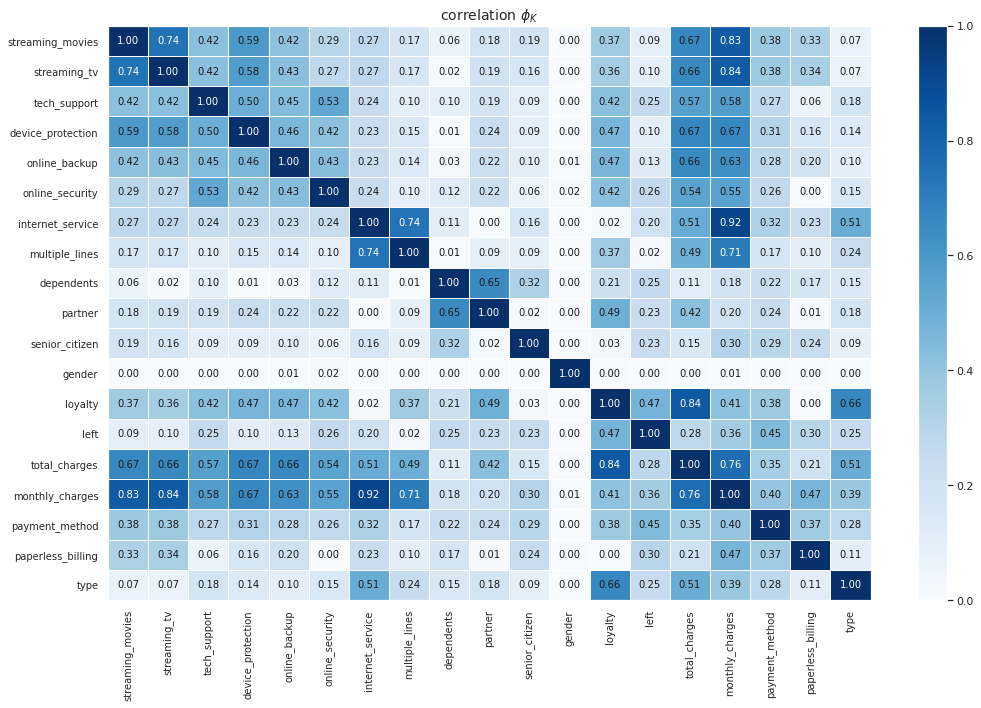

In [74]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.0, 
                        figsize=(15, 10))
plt.tight_layout()

### Conclusion
`monthly_charges` is highly dependent on a series of internet services, especially on `streaming_tv` and `streaming_movies`. It is noticeable that they are interdependent (obviously, streaming TV usually comes with streaming movies) with a correlation coefficient of 0.74. The correct solution would be to remove one column. Let's remove `streaming_tv`.

## Making changes according to the conclusion

In [75]:
df = df.drop('streaming_tv', axis=1)

## Splitting into Training and Testing

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('left', axis=1), df.left, test_size=0.25, random_state=171022)

## Feature Encoding

In [77]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_movies']

In [78]:
ohe_enc = OneHotEncoder(drop = 'first')

In [79]:
ohe_enc.fit(X_train[cat_features])

OneHotEncoder(drop='first')

In [80]:
new_columns = ohe_enc.get_feature_names(cat_features)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Encoding of the training dataset

In [81]:
X_train_ohe = pd.DataFrame(ohe_enc.transform(X_train[cat_features]).toarray(), columns = new_columns).reset_index(drop=True)

In [82]:
X_train_enc = X_train.drop(cat_features, axis=1).reset_index(drop=True)

In [83]:
X_train_enc = X_train_enc.join(X_train_ohe)

In [84]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         5282 non-null   float64
 1   total_charges                           5282 non-null   float64
 2   loyalty                                 5282 non-null   int64  
 3   senior_citizen                          5282 non-null   int64  
 4   type_One year                           5282 non-null   float64
 5   type_Two year                           5282 non-null   float64
 6   paperless_billing_Yes                   5282 non-null   float64
 7   payment_method_Credit card (automatic)  5282 non-null   float64
 8   payment_method_Electronic check         5282 non-null   float64
 9   payment_method_Mailed check             5282 non-null   float64
 10  gender_Male                             5282 non-null   floa

### Encoding of the testing dataset

In [85]:
X_test_ohe = pd.DataFrame(ohe_enc.transform(X_test[cat_features]).toarray(), columns = new_columns).reset_index(drop=True)

In [86]:
X_test_enc = X_test.drop(cat_features, axis=1).reset_index(drop=True)

In [87]:
X_test_enc = X_test_enc.join(X_test_ohe)

In [88]:
X_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         1761 non-null   float64
 1   total_charges                           1761 non-null   float64
 2   loyalty                                 1761 non-null   int64  
 3   senior_citizen                          1761 non-null   int64  
 4   type_One year                           1761 non-null   float64
 5   type_Two year                           1761 non-null   float64
 6   paperless_billing_Yes                   1761 non-null   float64
 7   payment_method_Credit card (automatic)  1761 non-null   float64
 8   payment_method_Electronic check         1761 non-null   float64
 9   payment_method_Mailed check             1761 non-null   float64
 10  gender_Male                             1761 non-null   floa

### Conclusion
We have successfully encoded the features using the `one-hot encoding` method.

## Training models

Let's train random forest and gradient boosting models and see their results (roc-auc) on cross-validation.

### Random Forest Classifier

In [89]:
clf_forest = RandomForestClassifier(random_state=171022)
parametrs_forest = {'n_estimators': range (1, 20, 5), 'max_depth': range (1, 8, 1)}
grid_forest = GridSearchCV(clf_forest, parametrs_forest, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
grid_forest.fit(X_train_enc, y_train)
grid_forest.best_params_
print('Лучший средний roc-auc на обучающей выборке:', round(grid_forest.best_score_, 2), ', для модели с параметрами:', grid_forest.best_params_)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Лучший средний roc-auc на обучающей выборке: 0.85 , для модели с параметрами: {'max_depth': 6, 'n_estimators': 16}


### CatBoost

In [90]:
params = {
'loss_function' : 'Logloss',
'custom_loss' : 'AUC:hints=skip_train~false',
'eval_metric' : 'AUC:hints=skip_train~false',
'verbose' : 200,
'random_seed' : 171022,
'cat_features' : cat_features
}

In [91]:
model = CatBoostClassifier(**params)

In [92]:
grid = {'learning_rate': [0.01, 0.1, 0.4], 'depth': [1, 4, 50], }

In [93]:
grid_search_result = model.grid_search(grid, X=X_train, y=y_train)

0:	learn: 0.6609121	test: 0.6681350	best: 0.6681350 (0)	total: 58.1ms	remaining: 58s
200:	learn: 0.8406407	test: 0.8436740	best: 0.8438178 (197)	total: 1.87s	remaining: 7.43s
400:	learn: 0.8480529	test: 0.8474016	best: 0.8474387 (375)	total: 3.23s	remaining: 4.82s
600:	learn: 0.8522749	test: 0.8504519	best: 0.8504843 (598)	total: 4.61s	remaining: 3.06s
800:	learn: 0.8552799	test: 0.8527181	best: 0.8528201 (793)	total: 5.92s	remaining: 1.47s
999:	learn: 0.8582794	test: 0.8550284	best: 0.8550284 (999)	total: 7.52s	remaining: 0us

bestTest = 0.8550283917
bestIteration = 999

0:	loss: 0.8550284	best: 0.8550284 (0)	total: 7.57s	remaining: 1m
0:	learn: 0.6609121	test: 0.6681350	best: 0.6681350 (0)	total: 6.11ms	remaining: 6.11s
200:	learn: 0.8636261	test: 0.8586585	best: 0.8588348 (198)	total: 1.42s	remaining: 5.64s
400:	learn: 0.8696053	test: 0.8631353	best: 0.8631353 (400)	total: 3.99s	remaining: 5.96s
600:	learn: 0.8738154	test: 0.8654851	best: 0.8656335 (594)	total: 6.14s	remaining: 4.08

In [94]:
model.get_params()

{'loss_function': 'Logloss',
 'random_seed': 171022,
 'verbose': 200,
 'custom_loss': 'AUC:hints=skip_train~false',
 'eval_metric': 'AUC:hints=skip_train~false',
 'cat_features': ['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'partner',
  'dependents',
  'multiple_lines',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_movies'],
 'depth': 4,
 'learning_rate': 0.4}

In [95]:
max(grid_search_result['cv_results']['test-AUC-mean'])

0.9034533555038023

### Conclusion
Cat Boost showed an `AUC-ROC` score of `0.90`, while Random Forest showed `0.85`. We choose Cat Boost and will test the model's quality on the test set.

## Testing the model on a test dataset

In [96]:
params = {
'loss_function' : 'Logloss',
'custom_loss' : 'AUC:hints=skip_train~false',
'eval_metric' : 'AUC:hints=skip_train~false',
'verbose' : 200,
'random_seed' : 171022,
'learning_rate': 0.12, 
'depth': 4,
'iterations': 1000,
'cat_features' : cat_features
}

In [97]:
model = CatBoostClassifier(**params)

In [98]:
model.fit(X_train, y_train, verbose=10)

0:	learn: 0.7983081	total: 7.36ms	remaining: 7.35s
10:	learn: 0.8520559	total: 82.6ms	remaining: 7.43s
20:	learn: 0.8647475	total: 150ms	remaining: 7.01s
30:	learn: 0.8738882	total: 225ms	remaining: 7.03s
40:	learn: 0.8777273	total: 296ms	remaining: 6.93s
50:	learn: 0.8807184	total: 378ms	remaining: 7.02s
60:	learn: 0.8854717	total: 448ms	remaining: 6.89s
70:	learn: 0.8874383	total: 519ms	remaining: 6.79s
80:	learn: 0.8908011	total: 601ms	remaining: 6.81s
90:	learn: 0.8939913	total: 676ms	remaining: 6.75s
100:	learn: 0.8971144	total: 760ms	remaining: 6.77s
110:	learn: 0.9015594	total: 839ms	remaining: 6.72s
120:	learn: 0.9061947	total: 917ms	remaining: 6.66s
130:	learn: 0.9089844	total: 991ms	remaining: 6.57s
140:	learn: 0.9121019	total: 1.06s	remaining: 6.47s
150:	learn: 0.9146031	total: 1.15s	remaining: 6.45s
160:	learn: 0.9181387	total: 1.25s	remaining: 6.52s
170:	learn: 0.9196972	total: 1.33s	remaining: 6.46s
180:	learn: 0.9221920	total: 1.41s	remaining: 6.38s
190:	learn: 0.9238392

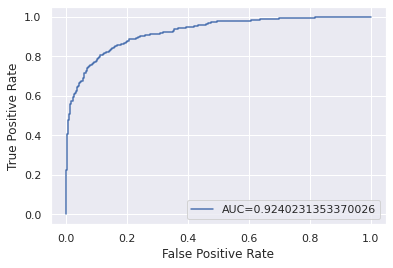


ROC-AUC metric value on the test set: 0.92402
Accuracy metric value on the test set: 0.88018


In [99]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
final_roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(final_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('')
print('ROC-AUC metric value on the test set:', round(final_roc_auc, 5))
final_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
print('Accuracy metric value on the test set:', round(final_accuracy, 5))

## Feature Importance Analysis

In [100]:
df_importance = {'feature': X_test.columns, 'importance': model.get_feature_importance()}
df_importance = pd.DataFrame(data=df_importance).sort_values(by='importance', ascending= False)
df_importance

,feature,importance
5,loyalty,56.416009
3,monthly_charges,11.573712
4,total_charges,10.079284
0,type,6.513554
11,internet_service,3.227057
2,payment_method,2.697286
10,multiple_lines,2.208928
1,paperless_billing,1.120432
6,gender,1.087121
15,tech_support,1.012856


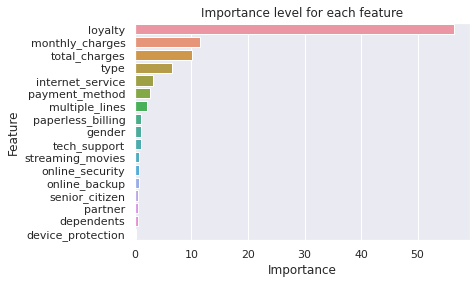

In [101]:
a = sns.barplot(x="importance", y="feature", data=df_importance)
a.set(xlabel='Importance', ylabel='Feature', 
      title='Importance level for each feature')
plt.show()

## Intermediate Conclusion

To predict customer churn, it was decided to take two models: Random Forest and Catboost, compare their results on cross-validation, determine the best model and its optimal hyperparameters, and test its quality on the test dataset.

The comparison was made using the ROC-AUC metric. The random forest model showed a result of `0.85`, while Catboost showed `0.9`. For the final test, we took the Catboost model with hyperparameters: `'depth': 4, 'learning_rate': 0.1` that we selected during the cross-validation process. We left the other hyperparameters with their default values.

As a result, the model showed a ROC-AUC metric value of `0.92252` on the test dataset, with an auxiliary accuracy metric of `0.88132`.

After obtaining the results, we displayed a diagram and the feature importance values. Noticeably, the most important feature for the model is the `loyalty` feature with a value of `55.8`. We keep information in this feature about how long the customer stayed with us before leaving or, if they did not leave, at the time of data extraction. Less significant but still outstanding features are `type: 6.595549`, `monthly_charges: 11.725656`, `total_charges: 10.220329`. These are contract type and numeric features: monthly payment and the amount the customer spent on services during their usage period.

## Work report

### Plan

The work was carried out according to the plan. Some changes, such as adding new features or changing the data type, were made as the work progressed, as further actions required.

### Difficulties

No significant difficulties arose during the work process.

### Key Steps

The main steps that allowed achieving a high value of the target metric were: preprocessing and merging of tables, filling in missing values in the final dataframe, and selecting the Catboost model.

### Model

The model was chosen from two contenders: Random Forest and Gradient Boosting. Hyperparameter tuning and cross-validation were conducted, resulting in the Catboost Gradient Boosting model with hyperparameters: `depth: 4, learning_rate: 0.1` performing the best. All categorical features were also passed to the model as `cat_features`, leaving the other hyperparameters as default.

### Features

All parameters were used for model training with little to no changes. All tables were merged into one, the target feature `left` was obtained based on the principle "if there is an end date in the contract data - the client has left, no - they have not," the number of days that the subscriber spent as a company client before leaving or at the time of data extraction from the database was calculated and separated into a separate feature `loyalty`. Date columns were removed to prevent interference with training. After studying the correlations, the feature `streaming_tv` was removed as it was highly correlated with the `streaming_movies` feature and could have degraded the final model quality.

List of features used for training: `type, paperless_billing, payment_method, monthly_charges,        total_charges, loyalty, gender, senior_citizen, partner,        dependents, multiple_lines, internet_service, online_security,        online_backup, device_protection, tech_support,        streaming_movies`

### Data Preprocessing

Data preprocessing mainly involved handling missing values resulting from table merging. After merging data on subscribers and contracts with data on internet services, missing values were filled with `no_internet` for one categorical feature and `No` for the rest of the binary features. This makes sense, as if a person does not use the internet, it is necessary to indicate this. The same approach was applied to the table on telephone services. Another issue related to data preprocessing arose at the very beginning: because the `TotalCharges` value contained spaces, the column acquired a string data type. This was discovered during the exploration of the `contract` table due to an error when applying the `.describe` method to the table. Looking at the contract data for these subscribers, it became clear that these were people who had just entered into a contract and had not yet had time to pay for their first month (the data had not yet been updated), so the data with spaces were replaced with values from the `MonthlyCharges` column, as it is assumed that subscribers pay in advance for a month.